In [3]:
import pandas as pd
import numpy as np
import gzip
from collections import defaultdict
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer,text_to_word_sequence

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences

In [4]:
vocab_size = 400000
embedding_size = 50
maxlen = 10
embeddings_path = 'glove.6B.50d.txt.gz'

In [6]:
import pandas as pd
from sklearn.cross_validation import train_test_split

df = pd.read_csv('Consumer_Complaints.csv', encoding='latin-1')
df = df[pd.notnull(df['Consumer complaint narrative'])]
train, test  = train_test_split( df, test_size=0.20, random_state=10)

In [7]:
train.shape

(196834, 18)

In [8]:
test.shape

(49209, 18)

In [9]:
train.head()

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
472832,05/15/2015,Mortgage,FHA mortgage,"Loan modification,collection,foreclosure",NaN,I am the sister and filing the complaint again...,NaN,"Dovenmuehle Mortgage, Inc.",FL,344XX,Older American,Consent provided,Web,05/15/2015,Closed with explanation,Yes,No,1378362
603094,11/23/2015,Mortgage,Conventional adjustable mortgage (ARM),"Application, originator, mortgage broker",NaN,"About a month ago, I inquired about the HARP p...",Company believes it acted appropriately as aut...,Ditech Financial LLC,CA,928XX,NaN,Consent provided,Web,11/23/2015,Closed with explanation,Yes,Yes,1668791
899867,11/20/2017,Debt collection,Credit card debt,Written notification about debt,Didn't receive notice of right to dispute,Creditor did provide information on how to dis...,Company has responded to the consumer and the ...,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,907XX,NaN,Consent provided,Web,11/22/2017,Closed with explanation,Yes,NaN,2733996
596705,02/22/2016,Debt collection,Credit card,Communication tactics,Frequent or repeated calls,The account is over the Statutes of Limitation...,Company chooses not to provide a public response,"BANK OF AMERICA, NATIONAL ASSOCIATION",NY,104XX,NaN,Consent provided,Web,02/22/2016,Closed with explanation,Yes,Yes,1797211
445194,04/24/2015,Debt collection,Payday loan,Improper contact or sharing of info,Talked to a third party about my debt,We received a phone call from XXXX from someon...,Company believes complaint caused principally ...,"Advance America, Cash Advance Centers, Inc.",VA,224XX,NaN,Consent provided,Web,04/24/2015,Closed with explanation,Yes,No,1345210


In [10]:
# Common methods to read data and get embeddings
def read_data():
    df_train = train
    df_val = test
    categories = list(set(df_train.Product.values))
    return df_train,df_val,categories

def load_embeddings():
    word_index = {}
    embeddings = np.zeros((vocab_size,embedding_size))
    with gzip.open(embeddings_path) as file:
        for i,line in enumerate(file):
            line_tokens = line.split()
            word = line_tokens[0].decode('utf8')
            embeddings[i] = np.asarray(line_tokens[1:],dtype='float32')
            word_index[word] = i
    return embeddings,word_index

In [11]:
def get_embedding(word,word_index,embeddings):
    if word in word_index:
        return embeddings[word_index[word]].reshape(((embedding_size,1)))
    else:
        return np.zeros((embedding_size,1))

In [12]:
# Methods for Neural Network Model
def prepare_data(df_train,df_val,categories):
    train_text = df_train['Consumer complaint narrative'].tolist()
    val_text = df_val['Consumer complaint narrative'].tolist()
    tk = Tokenizer(num_words = vocab_size, lower = True)
    tk.fit_on_texts(train_text + val_text)
    x_train = pad_sequences(tk.texts_to_sequences(train_text),maxlen=maxlen)
    x_val = pad_sequences(tk.texts_to_sequences(val_text),maxlen=maxlen)
    y_train = category_to_one_hot(df_train['Product'].values,categories)
    y_val = category_to_one_hot(df_val['Product'].values,categories) 
    return tk.word_index,x_train,y_train,x_val,y_val

def prepare_data_from_full_word_index(df_train,df_val,categories,word_index):
    train_text = df_train['Consumer complaint narrative'].tolist()
    val_text = df_val['Consumer complaint narrative'].tolist()
    x_train = get_pad_sequences(train_text,word_index)
    x_val = get_pad_sequences(val_text,word_index)
    y_train = category_to_one_hot(df_train['Product'].values,categories)
    y_val = category_to_one_hot(df_val['Product'].values,categories) 
    return word_index,x_train,y_train,x_val,y_val

def get_pad_sequences(text_list,word_index):
    seqs = []
    for text in text_list:
        word_seq = text_to_word_sequence(text.lower())
        seq = []
        for word in word_seq:
          if word in word_index:
            seq.append(word_index[word])
        seqs.append(seq)
    return pad_sequences(seqs,maxlen)


# Convert the list of categories to one_hot vector
def category_to_one_hot(cat_list,cat_master):
    cat_dict = {}
    for i,cat in enumerate(cat_master):
        cat_dict[cat] = i
    cat_integers = [cat_dict[cat] for cat in cat_list]
    return to_categorical(cat_integers,num_classes=len(cat_master))

# Convert one_hot to category
def one_hot_to_category(cat_one_hot_list,cat_master):
    return [cat_master[cat_one_hot.argmax()] for cat_one_hot in cat_one_hot_list]

# Get the embedding weights for the model
def get_embedding_matrix_for_model(embeddings,word_index):
    train_val_words = min(vocab_size, len(word_index)) +1
    embedding_matrix = np.zeros((train_val_words, embedding_size))
    for word, i in word_index.items():
        embedding_vector = get_embedding(word,word_index,embeddings).flatten()
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

# Build the keras model
def build_model(embedding_matrix,categories):
    model = Sequential()
    model.add(Embedding(embedding_matrix.shape[0], embedding_size, weights=[embedding_matrix],input_length=maxlen,trainable=False))
    model.add(LSTM(32))
#   We don't lose much by replacing LSTM with this flatten layer (as we have short sequences)
#   model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dense(len(categories), activation='sigmoid'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
    return model

def get_val(numerator,divisor):
    return float('nan') if divisor == 0 else np.round(numerator/divisor,3)

def analyze_predictions(categories,y_true,y_pred):
    tp = defaultdict(int)
    tn = defaultdict(int)
    fp = defaultdict(int)
    fn = defaultdict(int)
    precisions = []
    recalls = []
    f1s = []
    cat_counts = defaultdict(int)
    for cat in y_true:
        cat_counts[cat]+=1 
    correct = 0
    conf_mat = defaultdict(dict)
    for cat1 in categories:
        for cat2 in categories:
            conf_mat[cat1][cat2] = 0
    for y,y_hat in zip(y_true,y_pred):
        conf_mat[y][y_hat]+=1
        if y == y_hat:
            correct+=1
            tp[y]+=1
        else:
            fp[y_hat]+=1
            fn[y]+=1
    print('Overall Accuracy:',round(correct/len(y_pred),3))
    for cat in categories:
        precision = get_val(tp[cat],tp[cat]+fp[cat])
        recall = get_val(tp[cat],(tp[cat]+fn[cat]))
        f1 = get_val(2*precision*recall,precision + recall)
        precisions.append(precision)
        recalls.append(recall)  
        f1s.append(f1)
        print('{} --> Precision:{},Recall:{},F1:{}'.format(cat,precision,recall,f1))
    print ('\nAverages---> Precision:{}, Recall:{}, F1:{}'.format(np.round(np.nanmean(precisions),3),                                                                                                np.round(np.nanmean(recalls),3),
                                                               np.round(np.nanmean(f1s),3))
          )
          
    print('\nConfusion Matrix')
    for cat1 in categories:
        print('\n'  +cat1+'({}) --> '.format(cat_counts[cat1]),end='')
        for cat2 in categories:
            print('{}({})'.format(cat2,conf_mat[cat1][cat2]),end=' , ')
    print('')
    


# From Deep Learning with Python book
def make_history_plot(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', color='green',label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', color='green',label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [13]:
import numpy as np
np.random.seed(42) # for reproducibility
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
df_train,df_val,categories = read_data()

In [15]:
#Load Glove 50-d embeddings
embeddings,word_index = load_embeddings()

In [16]:
#Prepare the data for the model
tk_word_index,x_train,y_train,x_val,y_val = prepare_data_from_full_word_index(df_train,df_val,categories,word_index)

In [17]:
# Get the embedding matrix for the model, build model, display model summary
embedding_matrix = get_embedding_matrix_for_model(embeddings,word_index)
model = build_model(embedding_matrix,categories)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                10624     
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_2 (Dense)              (None, 18)                594       
Total params: 20,012,324
Trainable params: 12,274
Non-trainable params: 20,000,050
_________________________________________________________________


In [18]:
# Train the model, record history
history = model.fit(x_train, y_train,
                    epochs=5,
                    batch_size=24,
                    shuffle=False,
                    validation_data=(x_val, y_val))

Train on 196834 samples, validate on 49209 samples
Epoch 1/5
196834/196834 [==============================] - 96s 487us/step - loss: 2.0187 - acc: 0.3172 - val_loss: 1.9270 - val_acc: 0.3612
Epoch 2/5
196834/196834 [==============================] - 87s 443us/step - loss: 1.9030 - acc: 0.3718 - val_loss: 1.8884 - val_acc: 0.3762
Epoch 3/5
196834/196834 [==============================] - 84s 427us/step - loss: 1.8770 - acc: 0.3827 - val_loss: 1.8768 - val_acc: 0.3806
Epoch 4/5
196834/196834 [==============================] - 82s 418us/step - loss: 1.8639 - acc: 0.3873 - val_loss: 1.8697 - val_acc: 0.3855
Epoch 5/5
196834/196834 [==============================] - 91s 464us/step - loss: 1.8582 - acc: 0.3906 - val_loss: 1.8717 - val_acc: 0.3877


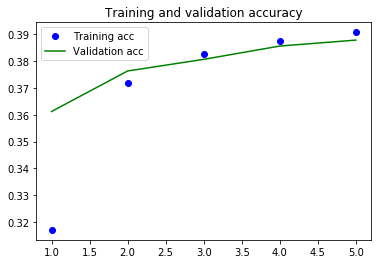

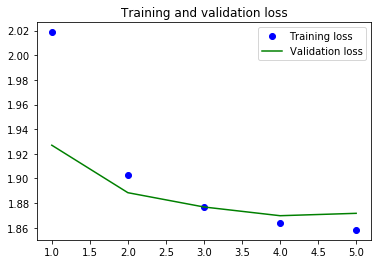

In [19]:
make_history_plot(history)

In [20]:
# Make and analyze training predictions
train_predictions = one_hot_to_category(model.predict(x_train),categories)
analyze_predictions(categories,df_train['Product'].values,train_predictions)

Overall Accuracy: 0.395
Consumer Loan --> Precision:0.457,Recall:0.061,F1:0.108
Mortgage --> Precision:0.377,Recall:0.626,F1:0.471
Payday loan, title loan, or personal loan --> Precision:nan,Recall:0.0,F1:nan
Money transfer, virtual currency, or money service --> Precision:nan,Recall:0.0,F1:nan
Credit reporting, credit repair services, or other personal consumer reports --> Precision:0.374,Recall:0.304,F1:0.335
Vehicle loan or lease --> Precision:nan,Recall:0.0,F1:nan
Credit reporting --> Precision:0.431,Recall:0.293,F1:0.349
Prepaid card --> Precision:nan,Recall:0.0,F1:nan
Other financial service --> Precision:nan,Recall:0.0,F1:nan
Credit card or prepaid card --> Precision:nan,Recall:0.0,F1:nan
Money transfers --> Precision:nan,Recall:0.0,F1:nan
Student loan --> Precision:0.628,Recall:0.187,F1:0.288
Virtual currency --> Precision:nan,Recall:0.0,F1:nan
Payday loan --> Precision:nan,Recall:0.0,F1:nan
Bank account or service --> Precision:0.309,Recall:0.304,F1:0.306
Checking or savings a

In [21]:
# Make and analyze validation predictions
val_predictions = one_hot_to_category(model.predict(x_val),categories)
analyze_predictions(categories,df_val['Product'].values,val_predictions)

Overall Accuracy: 0.388
Consumer Loan --> Precision:0.475,Recall:0.072,F1:0.125
Mortgage --> Precision:0.373,Recall:0.625,F1:0.467
Payday loan, title loan, or personal loan --> Precision:nan,Recall:0.0,F1:nan
Money transfer, virtual currency, or money service --> Precision:nan,Recall:0.0,F1:nan
Credit reporting, credit repair services, or other personal consumer reports --> Precision:0.365,Recall:0.291,F1:0.324
Vehicle loan or lease --> Precision:nan,Recall:0.0,F1:nan
Credit reporting --> Precision:0.407,Recall:0.282,F1:0.333
Prepaid card --> Precision:nan,Recall:0.0,F1:nan
Other financial service --> Precision:nan,Recall:0.0,F1:nan
Credit card or prepaid card --> Precision:nan,Recall:0.0,F1:nan
Money transfers --> Precision:nan,Recall:0.0,F1:nan
Student loan --> Precision:0.603,Recall:0.187,F1:0.285
Virtual currency --> Precision:nan,Recall:0.0,F1:nan
Payday loan --> Precision:nan,Recall:0.0,F1:nan
Bank account or service --> Precision:0.3,Recall:0.294,F1:0.297
Checking or savings acc